# Train a Small Neural Network to Recognize Digits



In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [2]:

class FCNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2.0/input_size)
        self.b1 = np.zeros(hidden_size1)
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2.0/hidden_size1)
        self.b2 = np.zeros(hidden_size2)
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(2.0/hidden_size2)
        self.b3 = np.zeros(output_size)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, x):
        # Forward pass
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.softmax(self.z3)
        return self.a3
    
    def backward(self, x, y, learning_rate):
        batch_size = x.shape[0]
        
        # Convert labels to one-hot encoding
        y_one_hot = np.zeros((batch_size, 10))
        y_one_hot[np.arange(batch_size), y] = 1
        
        # Backward pass
        dz3 = self.a3 - y_one_hot
        dW3 = np.dot(self.a2.T, dz3) / batch_size
        db3 = np.mean(dz3, axis=0)
        
        dz2 = np.dot(dz3, self.W3.T) * self.relu_derivative(self.z2)
        dW2 = np.dot(self.a1.T, dz2) / batch_size
        db2 = np.mean(dz2, axis=0)
        
        dz1 = np.dot(dz2, self.W2.T) * self.relu_derivative(self.z1)
        dW1 = np.dot(x.T, dz1) / batch_size
        db1 = np.mean(dz1, axis=0)
        
        # Update weights and biases
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1


In [3]:

def load_mnist_data():
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load training data
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    # Load test data
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Print dataset sizes
    print(f"Number of training images: {len(train_dataset)}")
    print(f"Number of test images: {len(test_dataset)}")

    
    return train_loader, test_loader


In [4]:
def train_network(network, train_loader, num_epochs, learning_rate):
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Convert PyTorch tensors to NumPy arrays
            x = data.numpy().reshape(data.shape[0], -1)  # Flatten the images
            y = target.numpy()
            
            # Forward pass
            output = network.forward(x)
            
            # Calculate cross-entropy loss
            predictions = np.argmax(output, axis=1)
            correct += np.sum(predictions == y)
            total += len(y)
            
            # Backward pass
            network.backward(x, y, learning_rate)
            
        accuracy = correct / total * 100
        print(f'Epoch {epoch+1}: Training Accuracy: {accuracy:.2f}%')


In [5]:

def evaluate_network(network, test_loader):
    correct = 0
    total = 0
    
    for data, target in test_loader:
        # Convert PyTorch tensors to NumPy arrays
        x = data.numpy().reshape(data.shape[0], -1)
        y = target.numpy()
        
        # Forward pass
        output = network.forward(x)
        predictions = np.argmax(output, axis=1)
        
        correct += np.sum(predictions == y)
        total += len(y)
    
    accuracy = correct / total * 100
    print(f'Test Accuracy: {accuracy:.2f}%')


In [8]:

def main():
    ############################################################
    # Load MNIST data
    ############################################################
    train_loader, test_loader = load_mnist_data()
    
    ############################################################
    # Display a 5x5 grid of random MNIST images
    ############################################################

    # Display a 5x5 grid of random MNIST images
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    
    # Get a batch of images from the training loader
    images, labels = next(iter(train_loader))
    
    # Randomly select 25 images
    indices = np.random.choice(len(images), 25, replace=False)
    
    for i, ax in enumerate(axes.flat):
        # Display image
        ax.imshow(images[indices[i]][0], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Label: {labels[indices[i]]}')
    
    plt.tight_layout()
    plt.show()

    ############################################################
    # Initialize network
    ############################################################
    input_size = 28 * 28  # MNIST images are 28x28
    hidden_size1 = 128
    hidden_size2 = 64
    output_size = 10  # 10 digits
    
    network = FCNetwork(input_size, hidden_size1, hidden_size2, output_size)
    
    ############################################################
    # Train the network
    ############################################################
    num_epochs = 3   # try 1, then 3, then 10 epochs
    learning_rate = 0.0001    # try 0.0001, then 0.01
    train_network(network, train_loader, num_epochs, learning_rate)
    
    ############################################################
    # Evaluate the network
    ############################################################
    evaluate_network(network, test_loader)


    ############################################################
    # Display a 5x5 grid of test images with predictions
    ############################################################
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    
    # Get a batch of test images
    test_images, test_labels = next(iter(test_loader))
    
    # Convert images to numpy and reshape for network
    test_images_np = test_images.numpy()
    test_images_flat = test_images_np.reshape(test_images_np.shape[0], -1)
    
    # Get predictions
    predictions = np.argmax(network.forward(test_images_flat), axis=1)
    
    # Randomly select 25 images
    indices = np.random.choice(len(test_images), 25, replace=False)
    
    for i, ax in enumerate(axes.flat):
        # Display image
        ax.imshow(test_images[indices[i]][0], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Pred: {predictions[indices[i]]}\nTrue: {test_labels[indices[i]]}')
    
    plt.tight_layout()
    plt.show()


Number of training images: 60000
Number of test images: 10000


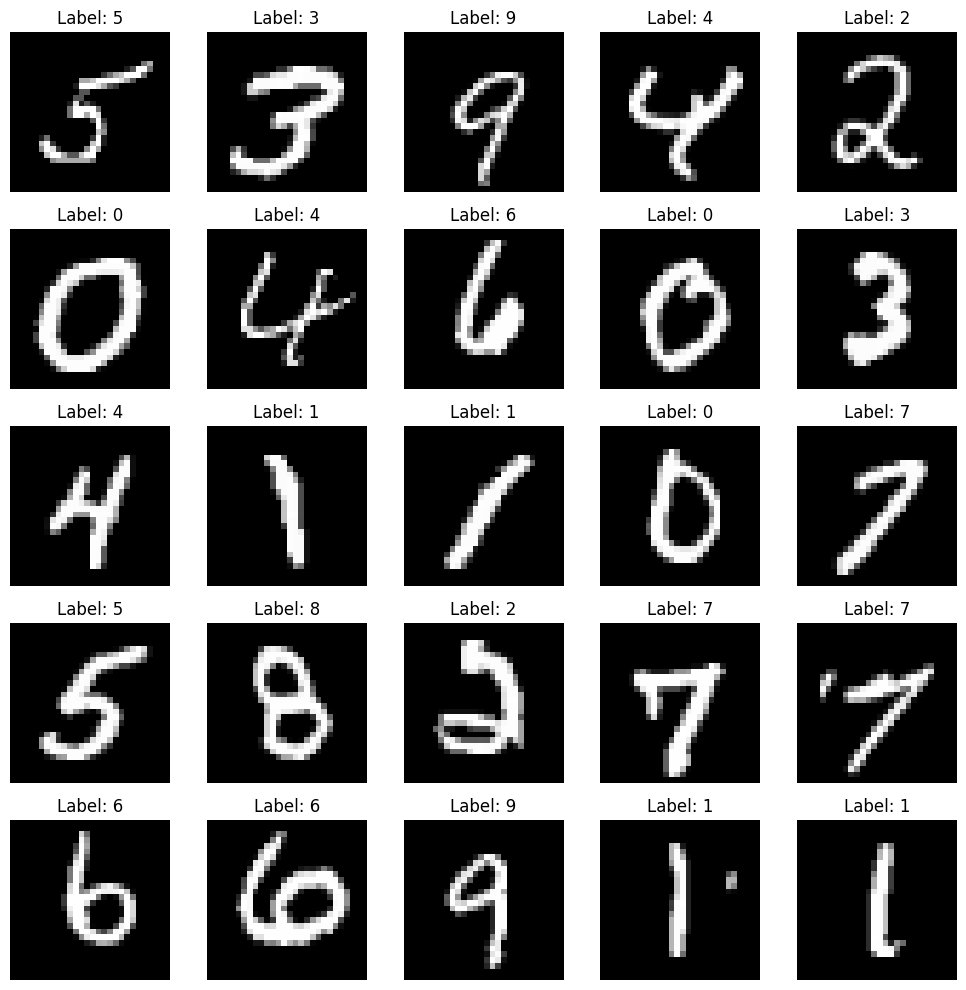

Epoch 1: Training Accuracy: 16.82%
Epoch 2: Training Accuracy: 41.34%
Epoch 3: Training Accuracy: 56.27%
Test Accuracy: 61.83%


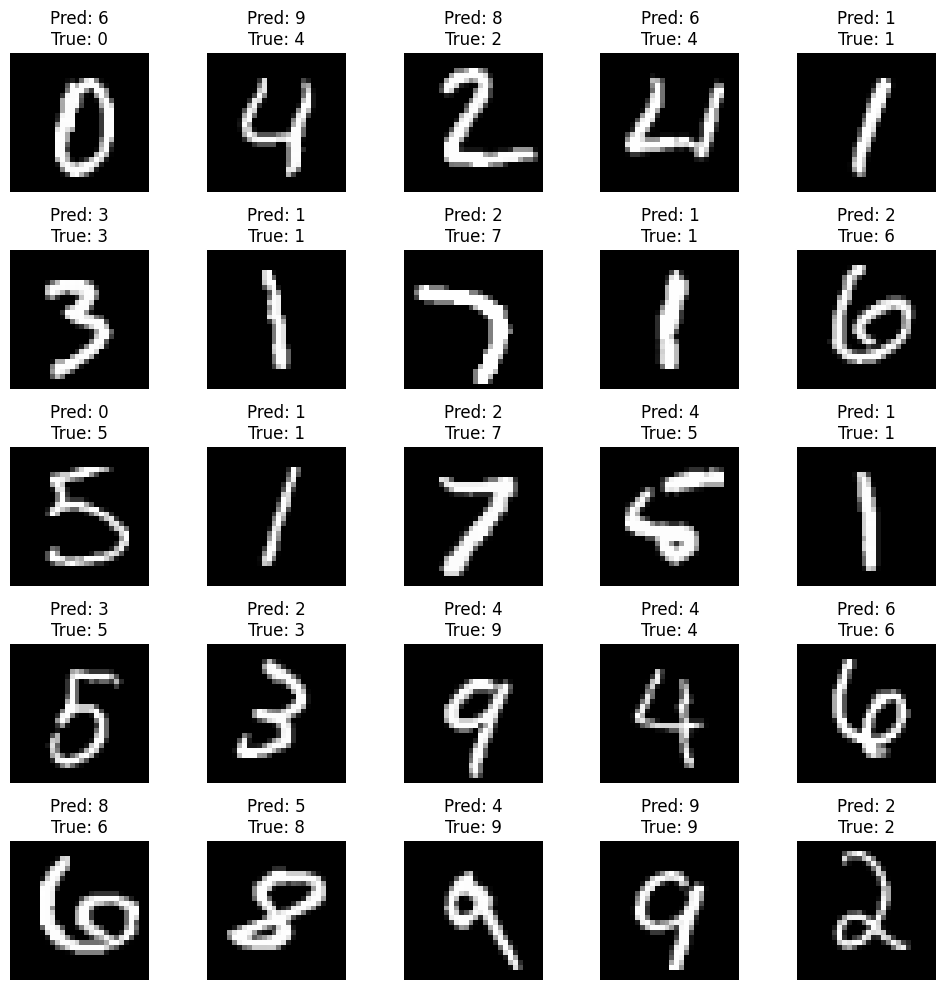

In [9]:

if __name__ == "__main__":
    main()